# Results Reproduction for Sets Validation 
Predictive modelling using neuroimaging data in the presence of confounds 
https://www.sciencedirect.com/science/article/pii/S1053811917300897

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
# The IXI_unbiased.csv is generated by running
# python utils.py
# which does very simple filtering
df = pd.read_csv("data/IXI_4x4x4/IXI_unbiased.csv")
df

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,FILENAME,SITE
0,16,1,172,63,1,2,1,5,1950-04-24,1,2005-06-24 00:00:00,55.17,swc1IXI016-Guys-0697-T1.nii,Guys
1,19,1,180,88,1,2,1,4,1946-11-02,1,2005-06-30 00:00:00,58.66,swc1IXI019-Guys-0702-T1.nii,Guys
2,28,1,172,70,1,2,5,3,1932-08-11,1,2006-08-21 00:00:00,74.03,swc1IXI028-Guys-1038-T1.nii,Guys
3,29,2,155,79,4,5,1,5,1946-08-29,1,2005-11-18 00:00:00,59.22,swc1IXI029-Guys-0829-T1.nii,Guys
4,50,1,180,79,1,4,2,5,1942-05-06,1,2005-07-13 00:00:00,63.19,swc1IXI050-Guys-0711-T1.nii,Guys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,606,1,178,86,1,1,8,5,1946-04-11,1,2006-10-25 00:00:00,60.54,swc1IXI606-HH-2601-T1.nii,HH
270,608,1,183,86,2,4,2,5,1954-04-26,1,2006-10-25 00:00:00,52.50,swc1IXI608-HH-2599-T1.nii,HH
271,610,1,180,75,1,2,5,4,1950-02-27,1,2006-11-01 00:00:00,56.68,swc1IXI610-HH-2649-T1.nii,HH
272,632,1,174,95,3,2,2,4,1950-05-25,1,2006-11-01 00:00:00,56.44,swc1IXI632-HH-2652-T1.nii,HH


## Population-of-Interest


"Site is not significantly associated with age in the resulting 272 subjects (2-sided Student's t-test, p = 0.77)"

**NOTE: Since the 2 discarded subjects mentioned in the paper are unknown, the p-value is estimated baed on the entire set**

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind

By default, the p-value is determined by comparing the t-statistic of the observed data against a theoretical t-distribution. When `1 < permutations < binom(n, k)`, where
 - `k` is the number of observations in a,
 - `n` is the total number of observations in a and b, and
 - `binom(n, k)` is the binomial coefficient (`n` choose `k`)

**NOTE: compare to conditional permutational test where the density function is being estimated from the data**

The statistic is calculated as `(np.mean(a) - np.mean(b))/se`, where `se` is the standard error. Therefore, the statistic will be positive when the sample mean of `a` is greater than the sample mean of `b` and negative when the sample mean of a is less than the sample mean of b.

In [3]:
def compute_ttest_p(df):
  group1 = df[df["SITE"]=="Guys"]["AGE"]
  group2 = df[df["SITE"]=="HH"]["AGE"]
  t_stat, p_value = ttest_ind(group1, group2)
  print(f'T-statistic: {t_stat}')
  print(f'P-value: {p_value}')

df = pd.read_csv("data/IXI_4x4x4/IXI_unbiased.csv")
compute_ttest_p(df)

T-statistic: 0.2637920072636834
P-value: 0.792139934648073


For model evaluation under confounding, we sample 4 biased training sets $B^1_1$, ..., $B^1_4$ of size 100 from $F^1$, each with significant associations between gender and MMSE (2-sided Student's t-test, p < 0.05), such that being male is aassociated with a higher MMSE score. These samples are produced by sampling from $F^1$ non-uniformly according to a model in which males are more likely to be chosen than females as the MMSE score increases.

**NOTE: the paper wasn't clear of how they exactly did the sampling**

In [4]:
print(f"# of subjects from Guys: {len(df[df['SITE'] == 'Guys'])}")
print(f"# of subjects from HH: {len(df[df['SITE'] == 'HH'])}")

# of subjects from Guys: 183
# of subjects from HH: 91


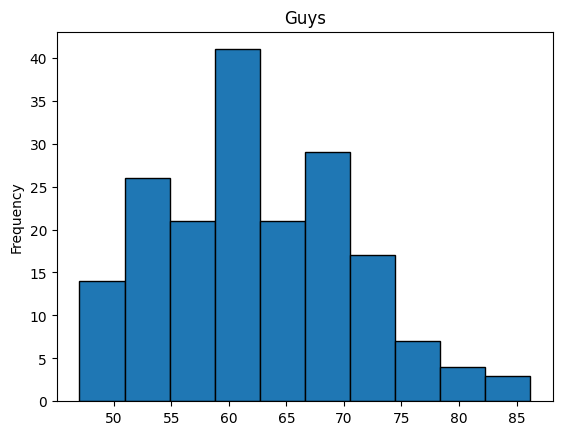

In [5]:

df[df['SITE'] == 'Guys']['AGE'].plot(kind='hist', bins=10, edgecolor='black')
plt.title("Guys")
plt.show()

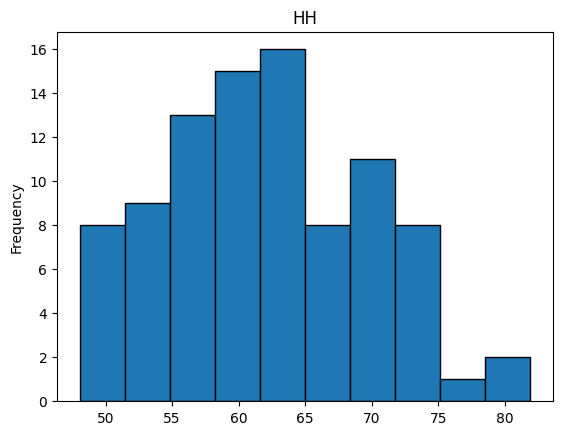

In [6]:
df[df['SITE'] == 'HH']['AGE'].plot(kind='hist', bins=10, edgecolor='black')
plt.title("HH")
plt.show()

## 1. Split the data in half

In [7]:
df_F1 = pd.concat([df[df["SITE"]=="Guys"].sample(n=len(df[df['SITE'] == 'Guys'])//2, random_state=45),
                   df[df["SITE"]=="HH"].sample(n=len(df[df['SITE'] == 'HH'])//2, random_state=18)])
df_F2 = df.drop(df_F1.index)
df_F1=df_F1.reset_index(drop=True)

In [8]:
compute_ttest_p(df_F1)
print(f"Guys {len(df_F1[df_F1['SITE']=='Guys'])}, HH {len(df_F1[df_F1['SITE']=='HH'])}")
compute_ttest_p(df_F2)
print(f"Guys {len(df_F2[df_F2['SITE']=='Guys'])}, HH {len(df_F2[df_F2['SITE']=='HH'])}")

T-statistic: 0.23577928785041474
P-value: 0.8139639219060985
Guys 91, HH 45
T-statistic: 0.13895953474035896
P-value: 0.8896876832960656
Guys 92, HH 46


**This satisfies p > 0.05 requirement**

## 2. Sample both biased and unbiased training sets $B^1_1, B^1_2, B^1_3, B^1_4$ and $B^2_1, B^2_2, B^2_3, B^2_4$

In [9]:
# The original paper didn't mention whether the ratio between the two sites, hence making the assumption of 65/35
# to match with the ratio with the original set  
def sampling_biased(df, max_iter=1000, seed=0):
  np.random.seed(seed)  # For reproducibility
  for i in range(max_iter):
    # Randomly sample equal numbers from both groups
    group1_sample = df[df["SITE"]=="Guys"].sample(n=65)
    group2_sample = df[df["SITE"]=="HH"].sample(n=35)
    
    # Compute the t-test on the two samples
    t_stat, p_value = ttest_ind(group1_sample["AGE"], group2_sample["AGE"])
    
    # Check if the result is significant
    if p_value < 0.05:
      print(f'Found significant sample on iteration {i+1}')
      print(f'T-statistic: {t_stat}')
      print(f'P-value: {p_value}')
      return pd.concat([group1_sample, group2_sample], ignore_index=True)
  
  print('No significant sample found.')
  return None, None

# Example usage:
# df is your original DataFrame
B_1_1 = sampling_biased(df_F1, max_iter=1000, seed=46)
B_1_2 = sampling_biased(df_F1, max_iter=1000, seed=49)
B_1_3 = sampling_biased(df_F1, max_iter=1000, seed=81)
B_1_4 = sampling_biased(df_F1, max_iter=1000, seed=94)

Found significant sample on iteration 622
T-statistic: 2.0941997473322225
P-value: 0.03882248146878711
Found significant sample on iteration 607
T-statistic: 2.1245598300770387
P-value: 0.0361393202183524
Found significant sample on iteration 212
T-statistic: 2.0619287806097715
P-value: 0.04186122837768778
Found significant sample on iteration 915
T-statistic: 2.0921530881862096
P-value: 0.03900938979706536


In [10]:
def sampling_unbiased(df, max_iter=1000, seed=0):
  np.random.seed(seed)  # For reproducibility
  for i in range(max_iter):
    # Randomly sample equal numbers from both groups
    group1_sample = df[df["SITE"]=="Guys"].sample(n=65)
    group2_sample = df[df["SITE"]=="HH"].sample(n=35)
    
    # Compute the t-test on the two samples
    t_stat, p_value = ttest_ind(group1_sample["AGE"], group2_sample["AGE"])
    
    # Check if the result is significant
    if p_value > 0.8:
      print(f'Found significant sample on iteration {i+1}')
      print(f'T-statistic: {t_stat}')
      print(f'P-value: {p_value}')
      return pd.concat([group1_sample, group2_sample], ignore_index=True)
  
  print('No significant sample found.')
  return None, None

# Example usage:
# df is your original DataFrame
B_2_1 = sampling_unbiased(df, max_iter=1000, seed=0)
B_2_2 = sampling_unbiased(df, max_iter=1000, seed=1)
B_2_3 = sampling_unbiased(df, max_iter=1000, seed=2)
B_2_4 = sampling_unbiased(df, max_iter=1000, seed=3)

Found significant sample on iteration 2
T-statistic: 0.15127352438138672
P-value: 0.8800709129419302
Found significant sample on iteration 3
T-statistic: 0.06475239221540076
P-value: 0.9485030500262895
Found significant sample on iteration 1
T-statistic: -0.15999758607078665
P-value: 0.8732122934389859
Found significant sample on iteration 3
T-statistic: -0.0399297800097772
P-value: 0.9682303424164503


# 3. Reproduce Age Prediction based on Gaussian Process Regression